# NLP with Disaster Tweets using RNN Techniques
*A machine learning process* 

### Overview
Understanding human languages is a challenging task for computers because our language has many rules, words, and meanings. We are able to write or speak figuratively using descriptive words. In the online social media website *Twitter*, many people are able to announce disasters and emergencies faster and easier than the news outlets, law enforcement, and/or government communication sites. For this reason, it would be ideal if a computer could recognize those emergency posts and classify them such that disaster relief can come to aide and news agencies are able to spread the word faster. However, because humans often use words for multiple meanings, we need to be able to identify what tweets are real disasters or emergencies, and which are not. We will be using Recursive Neural Network (RNN) machine learning techniques to attempt to classify natual language text. For this project we will be evaluated on the F1 score, which is written in the competition description as $F1 = 2*\frac{precision*recall}{precision+recall}$ where $precision = \frac{TP}{TP+FP}$ and $recall=\frac{TP}{TP+FN}$. 

This notebook will follow this layout, as per assignment guidelines:

1. Brief Description of the Problem and Data
2. Exploratory Data Analysis
3. Model Architecure
4. Results and Analysis
5. Conclusion

In [1]:
# install contractions if not already installed
!pip install contractions

In [2]:
# import libraries
import numpy as np
import pandas as pd
import random
import os

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

#work with text
import contractions
import re
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#create models
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.layers import Bidirectional, GRU
from tensorflow.keras.callbacks import EarlyStopping

#evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support

In [3]:
# get data
train_df = pd.read_csv('../input/nlp-getting-started/train.csv')
test_df = pd.read_csv('../input/nlp-getting-started/test.csv')
sample_submission = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

In [4]:
# set global constants
RANDOM_STATE = 49
STOPWORDS = set(stopwords.words('english'))

# 1. Brief Description of the Problem and Data

Once we load in the training data we are able to take a quick look at what we are given so that we have a better idea as to how to handle the data for processing and model training. Below, we can see this information. We notice we have 7613 entries (or rows) and five columns: id, keyword, location, text, target. The text column holds the tweet text which we will need to evaluate. We see that the text cells contain all sorts of characters such as lowercase letters, uppercase letters, numbers, punctuation, hastags (#), etc. We will work on fixing this later as well. Target is whether or not the text/tweet is a real disaster (1) or not (0). We are also given an id column which is simply the identifying number of that tweet. Lastly, we have keyword and location, which are both missing a good handful of their entries (which we will deal with in the preprocessing step). 


In [5]:
#show shape/dimensions of data
train_df.shape

In [6]:
# quick look at training data
train_df.head(-10)

We can below in two examples that a person may be able to easily identify which texts are real and which are not, however by looking at the examples we can see how a computer may get confused. For example, the first tweet below makes it pretty obvious there is an emergency however the second one is not as obvious that it is not an emergency; "heard a really loud bang" could be something serious such as an explosion or car crash, or it could not be urgent such as the wind or a cat knocking something over. Although it is difficult without more context (such as more information or a picture) we can begin to see why a computer may struggle to identify these differences. 

In [7]:
print(f'Text Example 1: {train_df["text"][2]} ==> TARGET: {train_df["target"][2]}')
print('\n')
print(f'Text Example 2: {train_df["text"][7593]} ==> TARGET: {train_df["target"][7593]}')

In [8]:
# describe data
train_df.describe()

In [9]:
# info data
train_df.info()

# 2. Exploratory Data Analysis (EDA) - Inspect, Visualize and Clean the Data

First, it is important to note from above that we are not missing any values from the text adn target columns. This will make it easier when preprocessing the data for the model. Below we can visualize the data to get a better understanding of it. 

First we see that the location column is missing about 33% of its values. Because of this, we will simply delete this column.

In [10]:
percentages_missing = train_df.isnull().sum() * 100 / len(train_df)

plt.figure(figsize=(15, 3))
sns.barplot(x=list(percentages_missing), 
            y=list(percentages_missing.index), 
            palette='colorblind').set(title='Missing Values', 
                                     xlabel='Percentage', 
                                     xlim=(0,50),
                                     xticks=range(0,55, 5))
plt.show();

In [11]:
# remove 'location' column
train_df = train_df.drop('location', axis=1)

Below we can see that our dataset is unbalanced because it has ~1000 more fake disaster tweets than it does real emergency tweets. Although there is this imbalance, we should still be able to create a fairly good model using the data available. 

In [12]:
# visualize targets
sns.countplot(data=train_df, x='target').set(title='Counts per Target Value');

Let's take a look at the most common keywords in the 'keyword' column. 

In [13]:
# create two dataframes, one for real emergencies and one for fake emergencies
fake_df = train_df[train_df['target']==0]
real_df = train_df[train_df['target']==1]

In [14]:
print("** Most Common Keywords for FAKE Tweets **")
fake_df['keyword'].value_counts()[:20]

In [15]:
print("** Most Common Keywords for REAL Tweets **")
real_df['keyword'].value_counts()[:20]

Although we can look at each of these and get a good idea of what is common and what is not in the keywords column, we also can visualize them in a plot. Below, we can see the top twenty most frequent keywords out of both fake and real tweets. 

In [16]:
#plot distribution of top 20 keywords
plt.figure(figsize=[10, 10])

sns.countplot(y='keyword', 
              data=train_df,
              order=train_df['keyword'].value_counts()[:20].index,
              hue='target',
              palette=['steelblue', 'darkorange']).set(title='Distribution of Top 20 Keywords', 
                                                      ylabel='Keywords')
plt.xticks(rotation=90)
plt.legend(loc='upper right')
plt.show();

### **Data Preprocessing**

Since the data is text from a social media site, we see a lot of URLs, HTMLs, @s, %20, and hashtags (#). We will remove the URLS, HTMLS and @ mentions so that we are working with more finite information pertaining directly to the text. We will not remove the %20 and #s as they hold important information. The %20 seem to be the keywords and hashtags are often used to call attention to a word on the Twitter site. For this reason, we will remove the symbols (%20 and #) but not the words connected to them. We will also remove punctuation so that we can focus soley on the words. We will however, count the amount of punctuation prior to removing the symbols, which could come in handy later when training the model. 

The following helper functions were inspired by royn5618 and can be found at https://www.kaggle.com/code/nabanitaroy/eda-and-tf-idf-prediction-model-with-80-accuracy. (remove urls, remove htmls, remove @ and #, count and remove punctuation) 

We will apply the following to our dataframe and text column:
1. Delete ‘location column’
2. Remove URLs, HTMLs, and tags
3. Count the number of punctuations present and delete them
4. Lowercase all words
5. Lemmatize words
6. Declare if numbers appear and delete them
7. Tokenize text

In [17]:
# remove urls
def remove_urls(text):
    url_pattern = r'(www.|http[s]?://)(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    return re.sub(url_pattern, '', text)

# remove hmtmls
def remove_html(text):
    html_entities = r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});'
    return re.sub(html_entities, '', text)

# remove @ and #
def remove_tags(text):
    tag_pattern = r'@([a-z0-9]+)|#'
    return re.sub(tag_pattern, '', text)

# count punctuation
def count_punctuation(text):
    getpunctuation = re.findall('[.?"\'`\,\-\!:;\(\)\[\]\\/“”]+?', text)
    return len(getpunctuation)

# put all words in lowercase
def lower_case(text):
    return text.lower()

In [18]:
# clean and lemmatize words 
def preprocess_text(x):
    cleaned_text = re.sub(r'[^a-zA-Z\d\s]+', '', x)
    word_list = []
    for each_word in cleaned_text.split(' '):
        word_list.append(contractions.fix(each_word).lower())
    word_list = [
        WordNetLemmatizer().lemmatize(each_word.strip()) for each_word in word_list
        if each_word not in STOPWORDS and each_word.strip() != ''
    ]
    return " ".join(word_list)

In [19]:
# apply to training data
functions = [remove_urls, remove_html, remove_tags, count_punctuation, lower_case, preprocess_text]
for func in functions: 
    if func == count_punctuation:
        train_df['punctuation_count'] = train_df['text'].apply(func)
    else:
        train_df['text'] = train_df['text'].apply(func) 

In the chart below we can see that how real emergency and fake emergency tweets differ when it comes to using punctuation in the post.

In [20]:
# visualize punctuation counts
plt.figure(figsize=(15, 5))

sns.countplot(x='punctuation_count', 
             data = train_df, 
             hue='target').set(title='Punctuation Counts', 
                              xlabel='Number of Punctuations in Tweet', 
                              ylabel='Number of Tweets')
plt.legend(loc='upper right')
plt.show();

Something else we can see in the data is that many tweets have numbers. First let's see how many tweets have numbers and if they tend more towards real or fake emergencies. 

In [21]:
# label if has numbers or not
def get_numbers(text):
    if re.findall(r'\d+', text): 
        return 1 
    else:
        return 0

In [22]:
# create column with numbers 
train_df['numbers'] = train_df['text'].apply(get_numbers)

In [23]:
# remove digits from text
def remove_digits(text):
    return re.sub(r'[0-9]+', '', text)

In [24]:
# apply remove digits
train_df['text'] = train_df['text'].apply(remove_digits)

Below we see that about half the the tweets that are real emergencies have numbers, while more than half of the fake tweets have numbers. Below we can take one more look at the final dataframe before begining model building and training.

In [25]:
# visualize if numbers were present
sns.countplot(x='target', 
             data=train_df, 
             hue='numbers',
             palette=['dimgrey','green']).set(title='Evaluating if Numbers Exist in Tweet', 
                               xlabel = 'Target', 
                               ylabel = 'Count') 
plt.legend(labels=['Absent', 'Present'])
plt.xticks(labels=['Fake (0)', 'Real (1)'], ticks=[0, 1])
plt.show();

In [26]:
# tokenize 
MAX_FEATURES = 3000
tokenizer = Tokenizer(num_words=MAX_FEATURES, split=' ')
tokenizer.fit_on_texts(train_df['text'].values)

token_X = tokenizer.texts_to_sequences(train_df['text'].values)
token_X = pad_sequences(token_X)

In [27]:
token_X.shape
token_df = pd.DataFrame(token_X)
for col_id in range(token_X.shape[1]):
    train_df[str(col_id)] = token_df[col_id]

In [28]:
# final look at data before starting model
train_df = train_df.drop('text', axis=1)
train_df = train_df.drop('keyword', axis=1)

train_df.head()

# 3. Model Architecure

Great! Our training data is all ready to go for the models. We will first split the data into training and validation sets before training.

For this project we decided to do two RNN models: LSTM and GRU. Both models are very simple to show how training a RNN model does not have to be complex. In fact LSTM and GRU models are similar in build as when building other neural networks, especially using Tensorflow Keras frameworks. 


Our LSTM model will have a Dropout and LSTM layer in its network. The GRU model will have an Bidirectional GRU layer. Both models will have an Embedding layer and Dense layer. For consistency, the output layers will have a sigmoid activation function, with an Adam loss function and a learning rate of 0.0001. During training, we will measure accuracy, loss, precision, and recall. 


1. **LSTM** --> Long-Short Term Memory models are a type of Recurrent Neural Network (RNN) which has specific gates to process the data. You can find more [here](https://towardsdatascience.com/lstm-recurrent-neural-networks-how-to-teach-a-network-to-remember-the-past-55e54c2ff22e) and/or [here](http://https://www.analyticsvidhya.com/blog/2021/03/introduction-to-long-short-term-memory-lstm/) which are great introductory resources into the mechancis of LSTM. 



2. **GRU** --> Gated Recurrent Unit (GRU) is another great RNN model to test with text data. Generally, GRUs perform better than LSTM models and can be faster. You can find more information about GRU models [here](https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be) and/or [here](https://www.analyticsvidhya.com/blog/2021/03/introduction-to-gated-recurrent-unit-gru/). 


In [29]:
# split data 80/20 training-validation
y = train_df['target']
X_train, X_valid, y_train, y_valid = train_test_split(train_df.loc[:, train_df.columns != 'id'], 
                                                      y, 
                                                      test_size=0.20, 
                                                      random_state=RANDOM_STATE)

In [30]:
# Setup GPU accelerator - configure Strategy. Assume TPU...if not set default for GPU/CPU
tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()

### **LSTM MODEL** 

In [31]:
#declare metrics for analysis during training
recall = tf.keras.metrics.Recall()
precision = tf.keras.metrics.Precision()

with strategy.scope():
# first model - LSTM
    model_LSTM = Sequential()
    model_LSTM.add(Embedding(input_dim=MAX_FEATURES,
                             output_dim=22, 
                             input_length=token_X.shape[1]))
    model_LSTM.add(Dropout(0.1))
    model_LSTM.add(LSTM(22, 
                        dropout=0.1, 
                        recurrent_dropout=0.25))
    model_LSTM.add(Dense(1, 
                         activation='sigmoid'))
    adam_optimizer = optimizers.Adam(learning_rate=0.0001)
    model_LSTM.compile(loss='binary_crossentropy', 
                       optimizer=adam_optimizer, 
                       metrics=['accuracy', recall, precision])
    model_LSTM.summary()

In [32]:
BATCH_SIZE = 32
EPOCHS = 8

# history
LSTM_history = model_LSTM.fit(X_train, 
                              y_train, 
                              epochs=EPOCHS, 
                              batch_size=BATCH_SIZE,
                              validation_data=(X_valid, y_valid))

In [33]:
# visualize
# graph accuracy
plt.plot(LSTM_history.history['accuracy'])
plt.plot(LSTM_history.history['val_accuracy'])
plt.title('LSTM Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

# graph loss
plt.plot(LSTM_history.history['loss'])
plt.plot(LSTM_history.history['val_loss'])
plt.title('LSTM Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

# graph precision
plt.plot(LSTM_history.history['precision'])
plt.plot(LSTM_history.history['val_precision'])
plt.title('LSTM Model Precision')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

#graph recall
plt.plot(LSTM_history.history['recall'])
plt.plot(LSTM_history.history['val_recall'])
plt.title('LSTM Model Recall')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

In [34]:
# predictions
predictions_LSTM = model_LSTM.predict(y_valid)
predictions_LSTM = np.transpose(predictions_LSTM)[0]
ypred_LSTM = list(map(lambda x: 0 if x < 0.5 else 1, predictions_LSTM))

In [35]:
precision, recall, f1_score, support =  precision_recall_fscore_support(y_valid, ypred_LSTM, zero_division=1, average='micro')
print('Precision = ', round(precision,5))
print('Recall    = ', round(recall, 5))
print('F1 Score  = ', round(f1_score, 5))

In [36]:
# confusion matrix
confmat = confusion_matrix(y_valid, ypred_LSTM)

display = ConfusionMatrixDisplay(confmat)
display.plot(cmap='coolwarm');

### **GRU MODEL**

In [37]:
#declare metrics for analysis during training
recall = tf.keras.metrics.Recall()
precision = tf.keras.metrics.Precision()

with strategy.scope():

# second model - GRU 
    model_GRU = Sequential()

    model_GRU.add(Embedding(input_dim=MAX_FEATURES,
                                 output_dim=22, 
                                 input_length=token_X.shape[1]))
    model_GRU.add(Bidirectional(GRU(32)))
    model_GRU.add(Dense(16, activation='relu'))
    model_GRU.add(Dense(1, activation='sigmoid'))
    
    model_GRU.compile(loss='binary_crossentropy', 
                       optimizer=adam_optimizer, 
                       metrics=['accuracy', recall, precision])
    model_GRU.summary()

In [38]:
# history
BATCH_SIZE = 32
EPOCHS = 4

# history
GRU_history = model_GRU.fit(X_train, 
                              y_train, 
                              epochs=EPOCHS, 
                              batch_size=BATCH_SIZE,
                              validation_data=(X_valid, y_valid))

In [39]:
# visualize
# graph accuracy
plt.plot(GRU_history.history['accuracy'])
plt.plot(GRU_history.history['val_accuracy'])
plt.title('GRU Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

# graph loss
plt.plot(GRU_history.history['loss'])
plt.plot(GRU_history.history['val_loss'])
plt.title('GRU Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

# graph precision
plt.plot(GRU_history.history['precision_1'])
plt.plot(GRU_history.history['val_precision_1'])
plt.title('GRU Model Precision')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

#graph recall
plt.plot(GRU_history.history['recall_1'])
plt.plot(GRU_history.history['val_recall_1'])
plt.title('GRU Model Recall')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

In [40]:
# predictions
predictions_GRU = model_GRU.predict(y_valid)
ypred_GRU = []
ypred_GRU = list(map(lambda x: 0 if x < 0.5 else 1, predictions_GRU))

In [41]:
precision, recall, f1_score, support =  precision_recall_fscore_support(y_valid, ypred_GRU, zero_division=1, average='micro')
print('Precision = ', round(precision,5))
print('Recall    = ', round(recall, 5))
print('F1 Score  = ', round(f1_score, 5))

In [42]:
# confusion matrix
confmat = confusion_matrix(y_valid, ypred_GRU)

display = ConfusionMatrixDisplay(confmat)
display.plot(cmap='coolwarm');

We can see both of the models needed very few epochs to converge (or get very close to converging). We played around with the number of epochs before settling on the above numbers. We see that the LSTM model took longer to get high metrics (and low loss) compared to the GRU model. Both models are suggesting great results when testing on the validation set. We can see in the plots how each model seemed to do during training.

# 4. Results and Analysis

The first step when testing on the test data (which is unseen and untouched so far) is to actually perform the same preprocessing techniques on it as we did to the training data. This will include: 
1. Delete ‘location column’
2. Remove URLs, HTMLs, and tags
3. Count the number of punctuations present and delete them
4. Lowercase all words
5. Lemmatize words
6. Declare if numbers appear and delete them
7. Tokenize text

After we preprocess the test data, we can then run each model and submit its predictions to the competition. This had to be done separately but we can see how the models performed in the screenshot below. 

In [43]:
#test set preprocessing
test_df = pd.read_csv('../input/nlp-getting-started/test.csv')

test_df = test_df.drop('location', axis=1)
test_df = test_df.drop(['keyword'], axis=1)

functions = [remove_urls, remove_html, remove_tags, count_punctuation, lower_case, preprocess_text]
for func in functions: 
    if func == count_punctuation:
        test_df['punctuation_count'] = test_df['text'].apply(func)
    else:
        test_df['text'] = test_df['text'].apply(func) 

test_df['numbers'] = test_df['text'].apply(get_numbers)

test_df['text'] = test_df['text'].apply(remove_digits)

test_token_X = tokenizer.texts_to_sequences(test_df['text'].values)
test_token_X = pad_sequences(test_token_X)
test_token_df = pd.DataFrame(test_token_X)
for col_id in range(test_token_X.shape[1]):
    test_df[str(col_id)] = test_token_df[col_id]
    
test_df = test_df.drop(['text'], axis=1)

In [44]:
test_preds = model_LSTM.predict(test_df.loc[:, test_df.columns != 'id'])
# test_preds = model_GRU.predict(test_df.loc[:, test_df.columns != 'id'])

In [45]:
ypreds_test = np.transpose(test_preds)[0]
ypreds_test = list(map(lambda x: 0 if x < 0.5 else 1, test_preds))

#convert to dataframe with ids
submission = pd.DataFrame({'id':test_df['id'], 'target':ypreds_test})

In [46]:
# submit model
submission.to_csv('submission.csv', index=False)

The first model using LSTM techniques got an F1 score of 0.57554, which is better than the GRU model which got an F1 score of 0.5378 on the test set. These values are a bit better than randomly guessing.

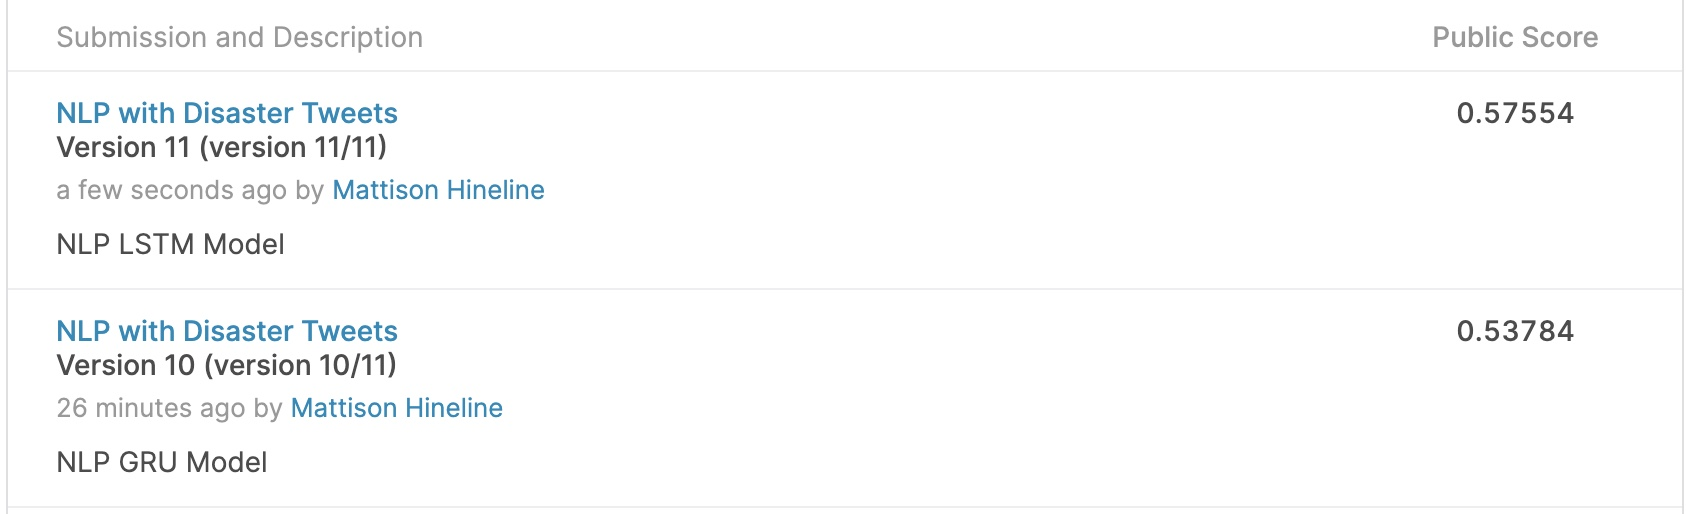

It is a little disappointing how our models performed. There are a few reasons as to why this could be:
1. Our model(s) were too simple for the data presented
2. Our cleaning was not the best for this data
3. Our model(s) were overfitting to the training data so therefore did not generalize well to new data. 
4. The model(s) were not the right model for the project
5. Not enough data to train with

There are many more reasons as to why our model performed a bit better than randomly guessing however, the suspicion is that our models were too simple *and* were overfitted. 

# 5. Conclusion

In this conclusion we will summarize the notebook procedure and results.

First we imported the data and got a good sense of what the training data looks like before we cleaned it. We also visualized much of the data too. Then we preprocessed the training data by counting punctuation, number appearance and modifying the text by making it easier for a computer to understand (see section 2. EDA above). After we had the training data ready, we split the training data into two subsets - training and validation - so that we could better train our models. Then we trained two models - LSTM and GRU - which we described in detail above by describing their hyperparameters, structure, and optimizers. Finally, we tested both models on the testing set and found our F1 score in the Kaggle competition page. 

Overall, the models performed less than we had hoped. However, these two models were both very simple and probably were overfitting to the training data. Based on the graphs showing the different metrics per epoch used in each model, we thought we had a good idea of how the models would perform; they seemed to be doing well! This is a good insight into future models and up-coming data scientist: just because the training and validation data seem to perform well does not necessarily mean your model is a good fit for any new data. Our models are a good example of this. Perhaps we could have gotten better results with more data, different text cleaning methods, fewer epochs (to prevent overfitting), or even differently structured models. 

-- END --